<a href="https://colab.research.google.com/github/dogabaskan/StoneScan/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import warnings

warnings.filterwarnings('ignore')

# Deep Learning Libraries (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout,
    GlobalAveragePooling2D, Activation, Add, GaussianNoise, Reshape,
    SpatialDropout2D, LeakyReLU, ReLU, Lambda, Input
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import (
    LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model, to_categorical

# Data Analysis and Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import cv2

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path

train_dir =  "/content/drive/MyDrive/RBC_borealis"


# Define paths for the four categories
normal_cases_dir =  Path('/content/drive/MyDrive/RBC_borealis/Normal')
cyst_cases_dir = Path('/content/drive/MyDrive/RBC_borealis/Cyst')
stone_cases_dir = Path('/content/drive/MyDrive/RBC_borealis/Stone')
tumor_cases_dir = Path('/content/drive/MyDrive/RBC_borealis/Tumor')

# Retrieve the list of images for each category
normal_cases = list(normal_cases_dir.glob('*.jpg'))
cyst_cases = list(cyst_cases_dir.glob('*.jpg'))
stone_cases = list(stone_cases_dir.glob('*.jpg'))
tumor_cases = list(tumor_cases_dir.glob('*.jpg'))

# Create a list of images and their labels
train_data = []

for img in cyst_cases:
    train_data.append((str(img), 1))  # Class Cyst = 1
for img in normal_cases:
    train_data.append((str(img), 0))  # Class Normal = 0
for img in stone_cases:
    train_data.append((str(img), 3))  # Class Stone = 3
for img in tumor_cases:
    train_data.append((str(img), 2))  # Class Tumor = 2

# Convert the list into a DataFrame
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Shuffle the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the data
print(train_data.head())


                                               image  label
0  /content/drive/MyDrive/RBC_borealis/Cyst/Cyst-...      1
1  /content/drive/MyDrive/RBC_borealis/Cyst/Cyst-...      1
2  /content/drive/MyDrive/RBC_borealis/Stone/Ston...      3
3  /content/drive/MyDrive/RBC_borealis/Cyst/Cyst-...      1
4  /content/drive/MyDrive/RBC_borealis/Tumor/Tumo...      2


Before Oversampling:
label_name
Normal    5081
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


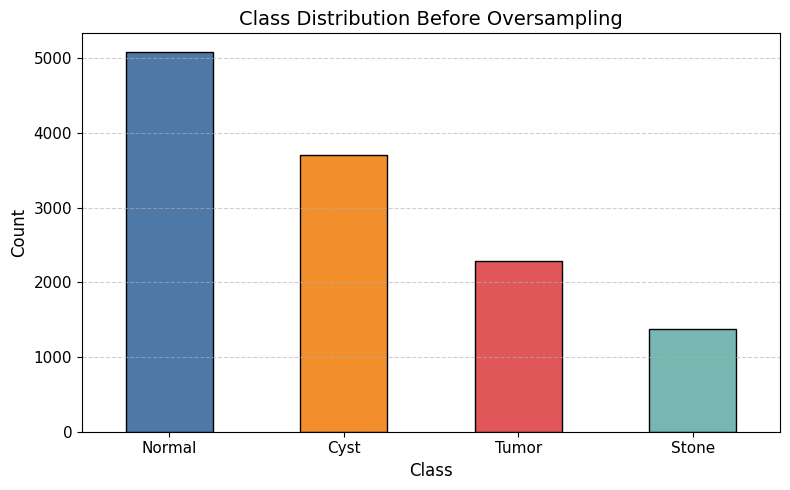

In [ ]:
import matplotlib.pyplot as plt
label_map = {0: 'Normal', 1: 'Cyst', 2: 'Tumor', 3: 'Stone'}
train_data['label_name'] = train_data['label'].map(label_map)
class_counts = train_data['label_name'].value_counts()
print("Before Oversampling:")
print(class_counts)

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

plt.figure(figsize=(8, 5))
class_counts.loc[list(label_map.values())].plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Class Distribution Before Oversampling", fontsize=14)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

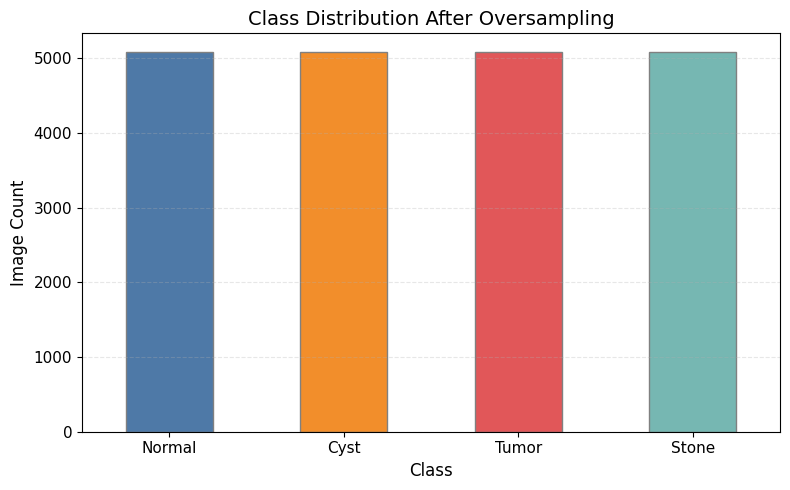

In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Recalculate max count for oversampling
class_counts = train_data['label'].value_counts()
max_count = class_counts.max()

# Oversample each class to match the max
balanced_data = []
for label, count in class_counts.items():
    subset = train_data[train_data['label'] == label]
    if count < max_count:
        subset = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_data.append(subset)

# Combine and shuffle
train_data_balanced = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

# Map numeric to name for visualization
label_map = {0: 'Normal', 1: 'Cyst', 2: 'Tumor', 3: 'Stone'}
train_data_balanced['label_name'] = train_data_balanced['label'].map(label_map)

# Count after balancing
after_counts = train_data_balanced['label_name'].value_counts()
order = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Soft, professional color palette
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# Plot
plt.figure(figsize=(8, 5))
after_counts.loc[order].plot(kind='bar', color=colors, edgecolor='gray')

plt.xlabel("Class", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.title("Class Distribution After Oversampling", fontsize=14)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from imblearn.over_sampling import RandomOverSampler


# Copy of the original training data
train_data_balanced = train_data.copy()

# Create a RandomOverSampler instance to balance the classes
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the data
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a new DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())

label
1    5081
3    5081
2    5081
0    5081
Name: count, dtype: int64


In [ ]:


# Split the dataset into training (80%) and testing (20%) with stratified sampling
train_data, test_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Verify the distribution
print("Training Set Distribution:\n", train_data['label'].value_counts())
print("Test Set Distribution:\n", test_data['label'].value_counts())

Training Set Distribution:
 label
0    4065
1    2967
2    1826
3    1102
Name: count, dtype: int64
Test Set Distribution:
 label
0    1016
1     742
2     457
3     275
Name: count, dtype: int64


In [ ]:
train_data['label'] = train_data['label'].astype(str)
test_data['label'] = test_data['label'].astype(str)


In [ ]:


# Create a copy of the original training data
train_data_balanced = train_data.copy()

# Initialize RandomOverSampler to balance class distribution
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to the dataset
X_resampled, y_resampled = oversampler.fit_resample(train_data_balanced[['image']], train_data_balanced['label'])

# Convert the resampled data into a DataFrame
train_data_balanced = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})

# Print the class distribution after oversampling
print(train_data_balanced['label'].value_counts())


label
1    4065
0    4065
2    4065
3    4065
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,           # Normalize pixel values to [0, 1]
    rotation_range=10,       # Rotate images by up to 10 degrees
    width_shift_range=0.12,  # Shift width by up to 12%
    height_shift_range=0.12, # Shift height by up to 12%
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Zoom in or out by up to 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels with the nearest values
)

# Initialize ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(rescale=1/255)

# Apply augmentation to the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_balanced,
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=True            # Shuffle data during training
)

# Prepare test data without augmentation
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',          # Column name for image paths
    y_col='label',          # Column name for labels
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,           # Use a batch size of 32
    class_mode='categorical', # Use categorical labels
    shuffle=False           # Do not shuffle test data
)

Found 16260 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


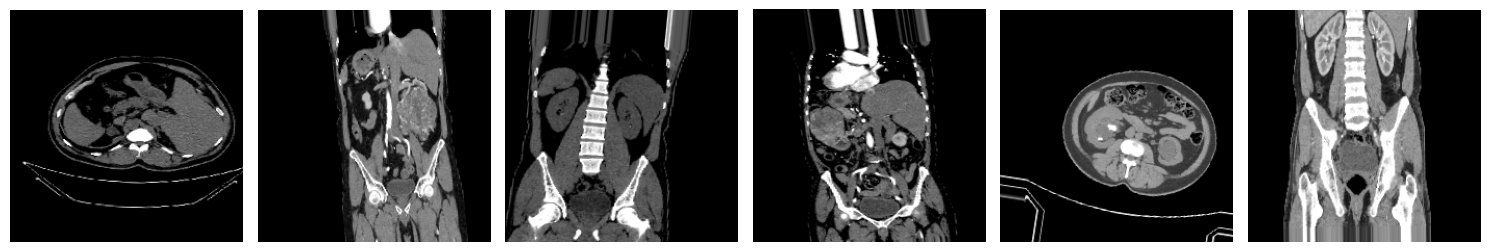

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 6

# Retrieve a batch of images from the generator
augmented_images, _ = next(train_generator)

# Ensure we don't exceed the available images
num_images = min(num_images, augmented_images.shape[0])

# Create a figure and display the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img = augmented_images[i]
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the [0, 1] range
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Build the model
model = Sequential()

# First layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(64, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Third layer: Convolutional + BatchNorm + MaxPooling
model.add(Conv2D(128, (3, 3)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Fourth layer: Convolutional + BatchNorm + MaxPooling

model.add(Conv2D(256, (3, 3),name = 'last_conv'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


# Replace Flatten with GlobalMaxPooling2D
model.add(GlobalMaxPooling2D())

# Fully Connected layers
model.add(Dense(256))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
model.add(Dense(128))
model.add(tf.keras.layers.LeakyReLU(alpha=0.01))



# Output layer: 4-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Setup Callbacks
checkpoint = ModelCheckpoint('./kidneymodel.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 489,540 (1.87 MB)

 Trainable params: 488,580 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
import tensorflow as tf

Epochs = 8

class UserPromptCallback(tf.keras.callbacks.Callback):
    def __init__(self, prompt_frequency, max_epochs=Epochs):
        super(UserPromptCallback, self).__init__()
        self.prompt_frequency = prompt_frequency
        self.max_epochs = max_epochs
        self.remaining_epochs = prompt_frequency

    def on_epoch_end(self, epoch, logs=None):
        # Stop if max_epochs is reached
        if epoch + 1 >= self.max_epochs:
            print(f"Reached maximum epoch {self.max_epochs}. Stopping training.")
            self.model.stop_training = True
            return

        # Ask user for input every 'prompt_frequency' epochs
        self.remaining_epochs -= 1
        if self.remaining_epochs <= 0:
            response = input(f"Epoch {epoch + 1} completed. Do you want to stop training or add more epochs? (stop/add): ").strip().lower()
            if response == 'stop':
                print("Stopping training as requested by the user.")
                self.model.stop_training = True
            elif response == 'add':
                try:
                    additional_epochs = int(input("How many more epochs to add? ").strip())
                    print(f"Added {additional_epochs} more epochs.")
                    self.max_epochs += additional_epochs  # Extend max_epochs
                    self.remaining_epochs = additional_epochs
                except ValueError:
                    print("Invalid input. Continuing training.")

# Create callback instance
user_prompt_callback = UserPromptCallback(prompt_frequency=20)
# Train model
history = model.fit(
    train_generator,
    epochs=Epochs,
    callbacks=[checkpoint,early_stopping,reduce_lr, user_prompt_callback],
    validation_data=test_generator
)
model.save('kidneymodel.keras')

# rest test_generator
test_generator.reset()

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Epoch 1/8
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8228 - loss: 0.4481
Epoch 1: val_loss improved from inf to 0.55182, saving model to ./kidneymodel.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 3225s 6s/step - accuracy: 0.8229 - loss: 0.4480 - val_accuracy: 0.7815 - val_loss: 0.5518 - learning_rate: 1.0000e-04
Epoch 2/8
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8988 - loss: 0.2751
Epoch 2: val_loss improved from 0.55182 to 0.24672, saving model to ./kidneymodel.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 3186s 6s/step - accuracy: 0.8988 - loss: 0.2751 - val_accuracy: 0.9016 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 3/8
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9375 - loss: 0.1758
Epoch 3: val_loss improved from 0.24672 to 0.13064, saving model to ./kidneymodel.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 3199s 6s/step - accuracy: 0.9375 - loss: 0.1758 - val_accuracy: 0.9486 - val_loss: 0.1306 - learning_rate: 1.0000e-04
Epoch 4/8
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/st

78/78 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step


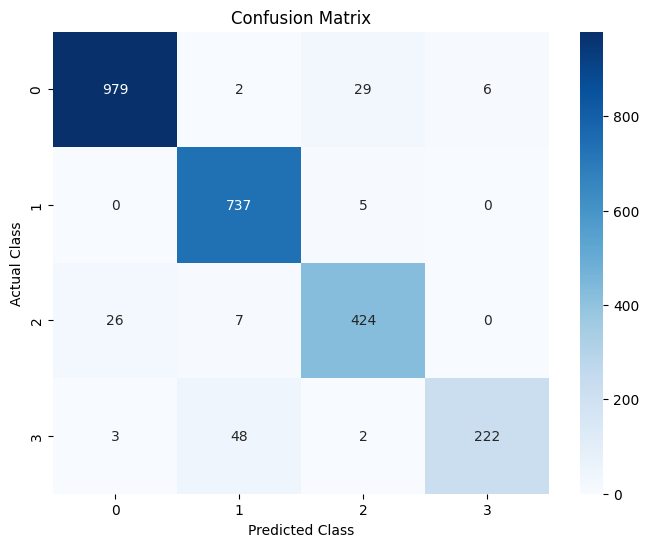

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1016
           1       0.93      0.99      0.96       742
           2       0.92      0.93      0.92       457
           3       0.97      0.81      0.88       275

    accuracy                           0.95      2490
   macro avg       0.95      0.92      0.93      2490
weighted avg       0.95      0.95      0.95      2490



NameError: name 'plot_metrics' is not defined

In [ ]:
#  Predictions for confusion matrix and classification report
y_true = test_generator.classes  # True labels from the test generator
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted class indices

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))
print("Classification Report:\n", class_report)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
plot_metrics(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

78/78 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9482 - loss: 0.1325
Test accuracy: 94.86%


In [ ]:
model.save('kidney_disease_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
 the image: /content/drive/MyDrive/RBC_borealis//Tumor/Tumor- (1052).jpg
Actual category: Tumor
Prediction Tumor
Confidence Percentage : 99.83%


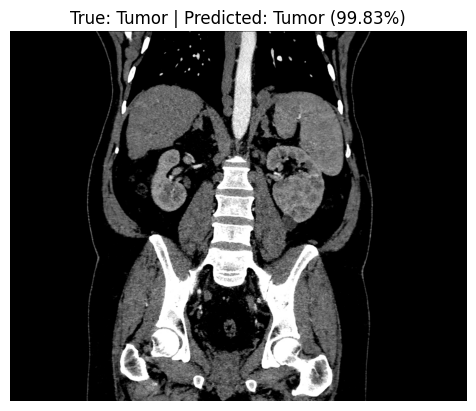

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model('./kidney_disease_model.keras')

class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)


    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype=np.float32) / 255.0
    image = np.expand_dims(image, axis=0)

    return image

def predict_image(image_path):

    true_class = os.path.basename(os.path.dirname(image_path))
    processed_image = preprocess_image(image_path)

    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f" the image: {image_path}")
    print(f"Actual category: {true_class}")
    print(f"Prediction {class_names[predicted_class]}")
    print(f"Confidence Percentage : {confidence * 100:.2f}%")


    plt.imshow(cv2.imread(image_path)[:, :, ::-1])
    plt.axis('off')
    plt.title(f"True: {true_class} | Predicted: {class_names[predicted_class]} ({confidence * 100:.2f}%)")
    plt.show()



image_path = r'/content/drive/MyDrive/RBC_borealis//Tumor/Tumor- (1052).jpg'
predict_image(image_path)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set base folder where test data is organized by class folders
test_dir = "/content/drive/MyDrive/RBC_borealis/splitted_data/test"
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Collect all image paths and true labels
image_data = []
for label in class_names:
    label_dir = os.path.join(test_dir, label)
    for fname in os.listdir(label_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(label_dir, fname)
            image_data.append((image_path, label))

# Generate predictions and build summary
results = []
y_true = []
y_pred = []

for image_path, true_class in tqdm(image_data):
    try:
        processed = preprocess_image(image_path)
        prediction = model.predict(processed, verbose=0)
        predicted_class_idx = int(np.argmax(prediction))
        predicted_class = class_names[predicted_class_idx]
        confidence = float(np.max(prediction)) * 100

        y_true.append(class_names.index(true_class))
        y_pred.append(predicted_class_idx)

        results.append({
            "image_path": image_path,
            "true_label": true_class,
            "predicted_label": predicted_class,
            "confidence_percentage": round(confidence, 2),
            "display_text": f"True: {true_class} | Predicted: {predicted_class} ({confidence:.2f}%)"
        })

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/prediction_results.csv", index=False)
print("✅ Saved batch prediction summary to /content/batch_prediction_results.csv")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


 59%|█████▊    | 1461/2492 [08:19<05:52,  2.93it/s]


KeyboardInterrupt: 

In [ ]:

import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Define your test directory and class labels
test_dir = "/content/drive/MyDrive/RBC_borealis/splitted_data/test"
class_names = ['Cyst', 'Tumor', 'Stone', 'Normal']

test_data = []
for label in class_names:
    label_path = os.path.join(test_dir, label)
    print(label_path)
    if not os.path.isdir(label_path):
        continue
    for fname in os.listdir(label_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            full_path = os.path.join(label_path, fname)
            test_data.append((full_path, label))
print(test_data)
# Create a DataFrame to store predictions
results = []

# Predict and store
for img_path, true_label in tqdm(test_data):
    try:
        img = load_img(img_path, target_size=(224, 224))
        array = img_to_array(img)
        array = np.expand_dims(array, axis=0) / 255.0
        preds = model.predict(array, verbose=0)
        pred_index = int(np.argmax(preds))
        pred_class = class_names[pred_index]
        confidence = float(np.max(preds)) * 100  # scale to percentage
        display_text = f"True: {true_label} | Predicted: {pred_class} ({confidence:.2f}%)"

        results.append({
            "image_path": img_path,
            "true_label": true_label,
            "predicted_label": pred_class,
            "confidence_percentage": round(confidence, 2),
            "display_text": display_text
        })
    except Exception as e:
        print(f"Failed to process {img_path}: {e}")

# Save to CSV
df_results = pd.DataFrame(results)
df_results.to_csv("/content/predictions_summary.csv", index=False)
print("Saved predictions to /content/predictions_summary.csv")

/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst
/content/drive/MyDrive/RBC_borealis/splitted_data/test/Tumor
/content/drive/MyDrive/RBC_borealis/splitted_data/test/Stone
/content/drive/MyDrive/RBC_borealis/splitted_data/test/Normal
[('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (1005).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (10).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (100).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (1003).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (1021).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (1024).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (101).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/splitted_data/test/Cyst/Cyst- (1018).jpg', 'Cyst'), ('/content/drive/MyDrive/RBC_borealis/s

100%|██████████| 2492/2492 [17:49<00:00,  2.33it/s]

Saved predictions to /content/predictions_summary.csv


In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/predictions_summary.csv", index=False)
print("Saved predictions to /content/drive/MyDrive/predictions_summary.csv")

Saved predictions to /content/drive/MyDrive/predictions_summary.csv


In [ ]:
import pandas as pd
from tqdm import tqdm

# Set base folder where test data is organized by class folders
test_dir = "/content/drive/MyDrive/RBC_borealis/splitted_data/test"
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Collect all image paths and true labels
image_data = []
for label in class_names:
    label_dir = os.path.join(test_dir, label)
    for fname in os.listdir(label_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(label_dir, fname)
            image_data.append((image_path, label))

# Generate predictions and build summary
results = []

for image_path, true_class in tqdm(image_data):
    try:
        processed = preprocess_image(image_path)
        prediction = model.predict(processed, verbose=0)
        predicted_class_idx = int(np.argmax(prediction))
        predicted_class = class_names[predicted_class_idx]
        confidence = float(np.max(prediction)) * 100

        results.append({
            "image_path": image_path,
            "true_label": true_class,
            "predicted_label": predicted_class,
            "confidence_percentage": round(confidence, 2),
            "display_text": f"True: {true_class} | Predicted: {predicted_class} ({confidence:.2f}%)"
        })

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/batch_prediction_results.csv", index=False)
print("✅ Saved batch prediction summary to /content/batch_prediction_results.csv")


100%|██████████| 2492/2492 [06:56<00:00,  5.98it/s]

✅ Saved batch prediction summary to /content/batch_prediction_results.csv


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,466,702 (5.60 MB)

 Trainable params: 488,580 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 977,162 (3.73 MB)

In [ ]:

# --- Grad-CAM Setup ---

import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Register hooks
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

def forward_hook(module, input, output):
    global activations
    activations = output

target_layer =  model.get_layer("last_conv")
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(lambda module, grad_input, grad_output: save_gradient(grad_output[0]))

# Grad-CAM computation
def generate_gradcam(model, input_tensor, target_class=None):
    model.eval()
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax().item()
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    weighted_activations = activations[0] * pooled_gradients.view(-1, 1, 1)
    heatmap = torch.sum(weighted_activations, dim=0)
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap.detach().cpu().numpy()

# Grad-CAM visualization
def show_gradcam_on_image(img_tensor, heatmap, alpha=0.5):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    overlay = alpha * heatmap_colored + (1 - alpha) * img
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()


AttributeError: 'Conv2D' object has no attribute 'register_forward_hook'

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,812 (1.80 MB)

 Trainable params: 470,916 (1.80 MB)

 Non-trainable params: 896 (3.50 KB)

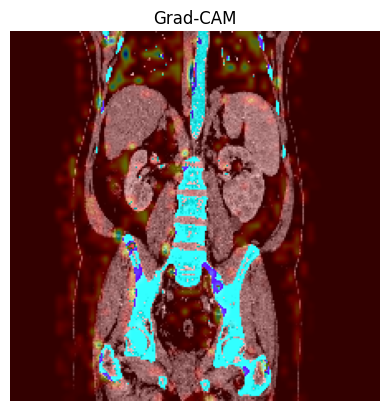

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input

# --- 1. Define CNN model using Functional API ---
inputs = Input(shape=(224, 224, 3))

x = layers.Conv2D(64, 3, padding='same')(inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, padding='same', name="last_conv")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()


# --- 2. Grad-CAM Functions ---

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="last_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()


# --- 3. Load image and run Grad-CAM ---

img_path = '/content/drive/MyDrive/RBC_borealis//Tumor/Tumor- (1052).jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Run Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model)
display_gradcam(np.uint8(img_array[0] * 255), heatmap)
